In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
cd drive/MyDrive/Dataset/PokemonData

/content/drive/MyDrive/Dataset/PokemonData


In [7]:
ls

loss_history.csv             Poke_test/   transformer_model.model/
my_transformer_model.model/  Poke_train/


In [5]:
!nvidia-smi

Mon May 31 17:50:07 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8    24W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [8]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

TRAINING CODE

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import os
import random
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

train_path = 'Poke_train'
test_path = 'Poke_test'


# Creating an image genertaor to apply random transformation on the images
image_gen = ImageDataGenerator(rotation_range=20,
                               rescale = 1./255,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               shear_range=0.1,
                               zoom_range=0.1,
                               horizontal_flip=True,
                               fill_mode='nearest')

# Setting the inupt image size
input_shape = (256,256,3)
num_classes = 150

"""
## Configure the hyperparameters
"""

learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 100
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 32
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 4
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier


train_image_gen = image_gen.flow_from_directory(train_path,
                                                target_size=input_shape[:2],
                                                color_mode='rgb',
                                                batch_size=batch_size,
                                                class_mode='categorical')



test_image_gen = image_gen.flow_from_directory(test_path,
                                                target_size=input_shape[:2],
                                                color_mode='rgb',
                                                batch_size=batch_size,
                                                class_mode='categorical')



"""
## Use data augmentation
"""

data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.Normalization(),
        layers.experimental.preprocessing.Resizing(image_size, image_size),
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(factor=0.02),
        layers.experimental.preprocessing.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)



class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches



"""
## Implement the patch encoding layer
The `PatchEncoder` layer will linearly transform a patch by projecting it into a
vector of size `projection_dim`. In addition, it adds a learnable position
embedding to the projected vector.
"""

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded


"""
## Implement multilayer perceptron (MLP)
"""

def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


#GET MODEL
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model



def run_experiment(model):

    model.compile(loss=keras.losses.CategoricalCrossentropy(from_logits=True), optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss',patience=3)

    history = model.fit(
        train_image_gen,
        batch_size=batch_size,
        epochs=200,
        validation_data=test_image_gen,
        callbacks=[early_stopping],
    )

    return history

model = create_vit_classifier()
history = run_experiment(model)


# Saving the trained model
tf.keras.models.save_model(
    model,
    "transformer_model.model",
    overwrite=True,
    include_optimizer=True
) 
model.save('my_transformer_model.model')




IMAGE GEN XTRAIN AND YTRAIN
Found 6820 images belonging to 150 classes.
Found 2246 images belonging to 150 classes.
Epoch 1/200
27/27 [==============================] - 2241s 83s/step - loss: 5.4707 - accuracy: 0.0075 - val_loss: 5.0133 - val_accuracy: 0.0089
Epoch 2/200
27/27 [==============================] - 149s 6s/step - loss: 5.0503 - accuracy: 0.0062 - val_loss: 4.9348 - val_accuracy: 0.0116
Epoch 3/200
27/27 [==============================] - 150s 6s/step - loss: 4.9381 - accuracy: 0.0147 - val_loss: 4.7401 - val_accuracy: 0.0209
Epoch 4/200
27/27 [==============================] - 148s 6s/step - loss: 4.7794 - accuracy: 0.0161 - val_loss: 4.5661 - val_accuracy: 0.0218
Epoch 5/200
27/27 [==============================] - 148s 6s/step - loss: 4.6046 - accuracy: 0.0260 - val_loss: 4.3732 - val_accuracy: 0.0419
Epoch 6/200
27/27 [==============================] - 148s 6s/step - loss: 4.4621 - accuracy: 0.0345 - val_loss: 4.1236 - val_accuracy: 0.0699
Epoch 7/200
27/27 [===========

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: transformer_model.model/assets


INFO:tensorflow:Assets written to: transformer_model.model/assets
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: my_transformer_model.model/assets


INFO:tensorflow:Assets written to: my_transformer_model.model/assets


GENERATE STATISTICS PLOTS

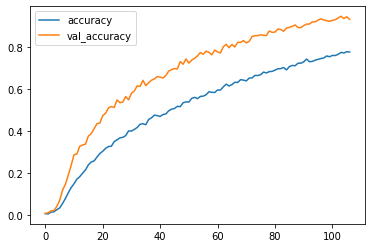

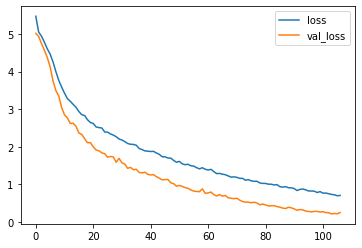

In [8]:
loss_history = pd.read_csv("loss_history.csv") 

# plotting the accuracy
loss_history[['accuracy','val_accuracy']].plot()
# plotting the loss
loss_history[['loss','val_loss']].plot()

LOAD MODEL AND GENERATE STATISTICS PLOTS TO AVOID TRAINING AGAIN

Found 6820 images belonging to 150 classes.


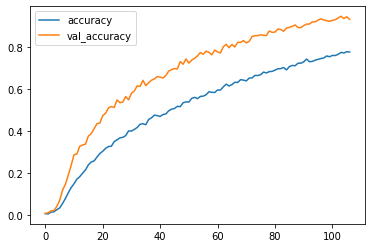

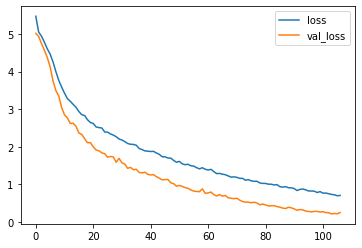

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential,load_model
from tensorflow import keras



train_path = 'Poke_train'
test_path = 'Poke_test'

batch_size = 256
input_shape = (256,256,3)

image_gen = ImageDataGenerator(rotation_range=20,
                               rescale = 1./255,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               shear_range=0.1,
                               zoom_range=0.1,
                               horizontal_flip=True,
                               fill_mode='nearest')

train_image_gen = image_gen.flow_from_directory(train_path,
                                                target_size=input_shape[:2],
                                                color_mode='rgb',
                                                batch_size=batch_size,
                                                class_mode='categorical')

model = load_model("transformer_model.model")

loss_history = pd.read_csv("loss_history.csv") 

# plotting the accuracy
loss_history[['accuracy','val_accuracy']].plot()
# plotting the loss
loss_history[['loss','val_loss']].plot()

FUNCTION TO PREDICT THE POKEMONS

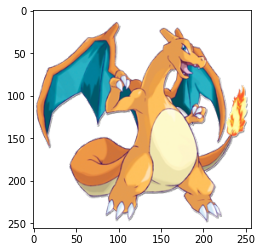

Charizard


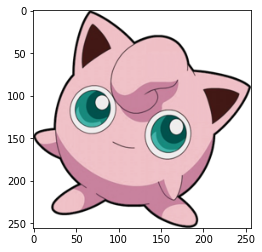

Jigglypuff


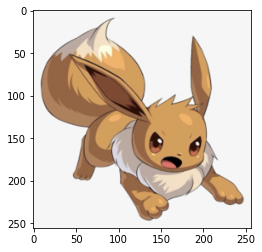

Eevee


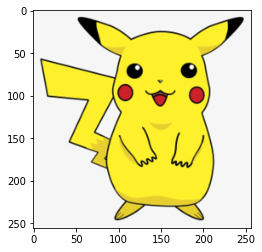

Pikachu


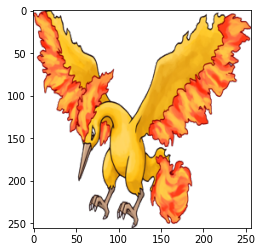

Moltres


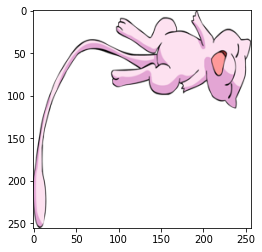

Mew


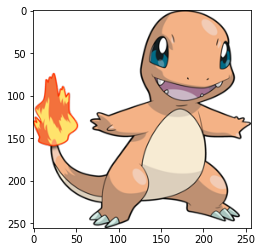

Charmander


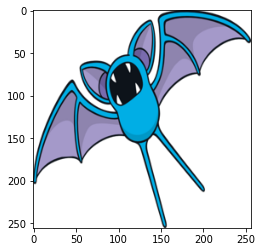

Zubat


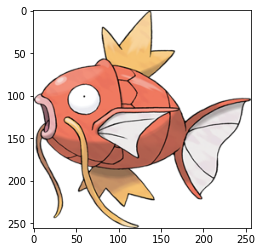

Magikarp


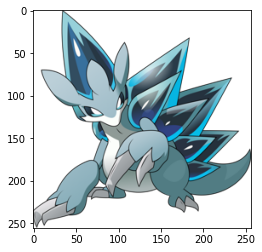

Alolan Sandslash


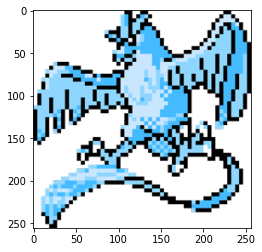

Articuno


In [15]:
# Importing standard libraries for image and web url
from tensorflow.keras.preprocessing import image
from PIL import Image
import urllib.request

def predict_pokemon(img_url):

  # Fetching Image URL 
  url = img_url
  test_image_path = urllib.request.urlopen(url)
  
  # Using Image lib to resize image
  img = Image.open(test_image_path)
  img = img.resize((256,256))
  
  plt.imshow(img)
  plt.show()
  
  # Dropping the transperency channel if it exists
  
  img = np.array(img)
  if img.shape[2] != 3:
      img = img[:,:,:3]
  
  # Converting to array, normalizing and expanding the dims
  
  img = img/255
  my_img_array = np.expand_dims(img,axis=0)

  # Fething the prediction
  pred_class = np.argmax(model.predict(my_img_array),axis=-1)
  poke_class = {value:key for key,value in train_image_gen.class_indices.items()}
  print(poke_class[pred_class[0]])


img = 'http://www.pngmart.com/files/12/Pokemon-Charizard-PNG-Image.png'
img2 = 'https://www.pngkey.com/png/full/149-1492440_pokemon-jigglypuff-png-jigglypuff-pokemon.png'
img3 = 'https://smallimg.pngkey.com/png/small/62-623293_pokemon-conquest-pokemon-art.png'
img4 = 'https://smallimg.pngkey.com/png/small/1-16272_pokemon-logo-png-transparent-pokemon-vector.png'
img5 = 'https://www.pngkey.com/png/full/62-622689_fire-pokemon-png-moltres-pokemon.png'
img6 = 'https://www.pngkey.com/png/full/202-2022901_mew-transparent-flying-pokemon-mew-no-background.png'
img7 = 'https://www.pngkey.com/png/full/12-128641_stats-moves-evolution-locations-other-forms-charmander-pokemon.png'
img8 = 'https://www.pngkey.com/png/full/172-1721977_zubat-dream-pokemons-zubat.png'
img9 = 'https://www.pngkey.com/png/full/99-992619_magikarp-pokemon-magikarp.png'
img10 = 'https://www.pngkey.com/png/full/3-35365_pokemon-vector-sandslash-and-alolan-sandslash.png'
img11 = 'https://www.pngkey.com/png/full/897-8978333_articuno-articuno-pixel-art.png'

pokemon = [img,img2,img3,img4,img5,img6,img7,img8,img9,img10,img11]

for i in pokemon:
  predict_pokemon(i)